## CSCN8010 - Lab10
## Lifei Wang 8855277    

1. Obtain the Data

In [21]:
# find 3 highest images within dataset
# reference: https://stackoverflow.com/questions/16910330/return-total-number-of-files-in-directory-and-subdirectories
import os

train_path = './train/'
test_path = './test/'
validation_path = './valid/'

# initialize an empty dictionary to count images for each folder in dataset
img_count = {}

def count_images(dir_path):
    folder = os.scandir(dir_path)
    files = 0
    for path in folder:
        if path.is_file():
            files += 1
    return files

def find_top3_classes(dir_path):
    for folder in os.scandir(dir_path):
        if folder.is_dir():
            folder_name = folder
            img_count[folder_name] = count_images(folder.path)

# use train folder to find top 3 classes
find_top3_classes(train_path)

# sort in descending order
img_count_sorted = sorted(img_count.items(), key=lambda item: item[1], reverse=True)

img_count_sorted[:3]

[(<DirEntry 'RUFOUS TREPE'>, 263),
 (<DirEntry 'HOUSE FINCH'>, 248),
 (<DirEntry 'D-ARNAUDS BARBET'>, 233)]

According to the output, the top 3 classes are RUFOUS TREPE, HOUSE FINCH and D-ARNAUDS BARBET.

In [22]:
# delete other folders
top_3_class = ['RUFOUS TREPE', 'HOUSE FINCH', 'D-ARNAUDS BARBET']

def remove_folder(dir_path):
    for entry in os.scandir(dir_path):
        if entry.is_file():
            os.remove(entry.path)
        elif entry.is_dir() and entry.name not in top_3_class:
            # recursively call the function to remove the files inside
            remove_folder(entry.path)
            # remove empty folder after removing files
            os.rmdir(entry.path)

# call the function for three folders
remove_folder(train_path)
remove_folder(test_path)
remove_folder(validation_path)

2. Use data-augmentation to increase the number of training images. You are encouraged to try out various augmentation methods supported by Keras.

In [23]:
from tensorflow.keras.utils import image_dataset_from_directory

train_data = image_dataset_from_directory(train_path, image_size=(224,224), batch_size=32)
validation_data = image_dataset_from_directory(validation_path, image_size=(224,224), batch_size=32)
test_data = image_dataset_from_directory(test_path, image_size=(224,224), batch_size=32)

Found 744 files belonging to 3 classes.
Found 15 files belonging to 3 classes.
Found 15 files belonging to 3 classes.


In [39]:
from keras.preprocessing.image import ImageDataGenerator

augmented_data = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

validation_data_generator = ImageDataGenerator(rescale = 1.0/255)

train_generator = augmented_data.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = augmented_data.flow_from_directory(
    validation_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

Found 744 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


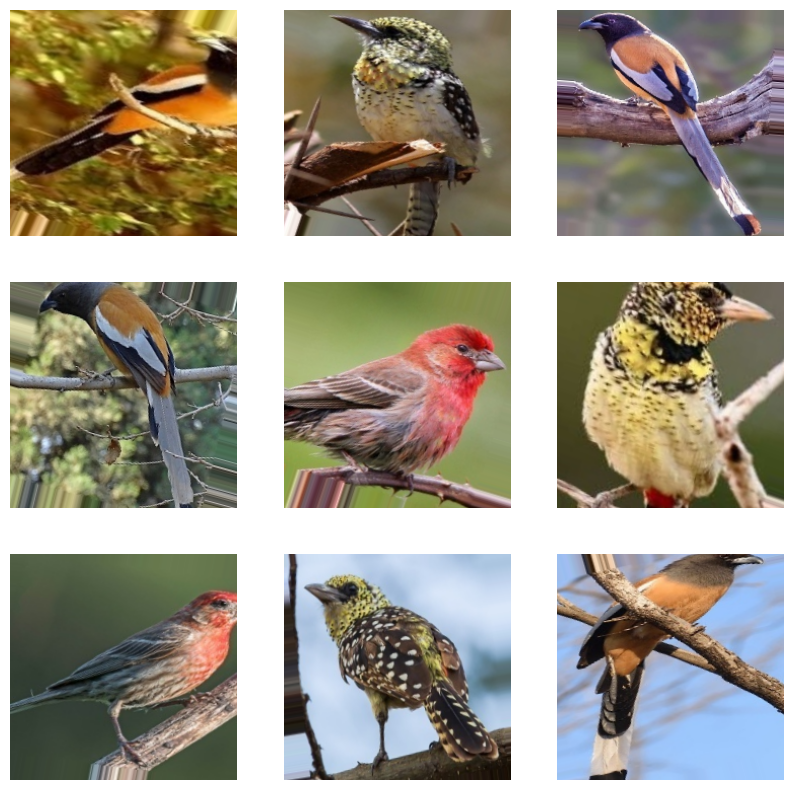

In [44]:
# display augmented training images
import matplotlib.pyplot as plt

img, _ = next(train_generator)

plt.figure(figsize=(10,10))

for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(img[i].astype('uint8'))
    plt.axis('off')
plt.show()

3. Fine-Tune `VGG16` (pre-trained on `imagenet`), to classify the 3 classes

In [45]:
# load vgg model from imagenet
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [71]:
# custom layers for fine-tuning
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# free all layers for base_model
for layer in base_model.layers:
    layer.trainable=False

inputs = tf.keras.Input(shape=(224, 224, 3))

x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 3)                 1539      
                                                           

In [72]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
24/24 [==============================] - 42s 2s/step - loss: 1.4238 - accuracy: 0.8172 - val_loss: 1.4666 - val_accuracy: 0.9333
Epoch 2/10
24/24 [==============================] - 46s 2s/step - loss: 0.4526 - accuracy: 0.9395 - val_loss: 2.2248 - val_accuracy: 0.8667
Epoch 3/10
24/24 [==============================] - 62s 3s/step - loss: 0.2562 - accuracy: 0.9624 - val_loss: 6.8522e-04 - val_accuracy: 1.0000
Epoch 4/10
24/24 [==============================] - 56s 2s/step - loss: 0.1700 - accuracy: 0.9745 - val_loss: 6.1805e-04 - val_accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 56s 2s/step - loss: 0.0940 - accuracy: 0.9812 - val_loss: 6.4373e-07 - val_accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 56s 2s/step - loss: 0.1230 - accuracy: 0.9785 - val_loss: 8.0267e-07 - val_accuracy: 1.0000
Epoch 7/10
24/24 [==============================] - 56s 2s/step - loss: 0.1105 - accuracy: 0.9718 - val_loss: 4.2346e-04 - val_accuracy: 1.0000


4. Explore the model performance: accuracy, confusion metric, precision, recall, F1-score, precision-recall curve and its area under the curve (AUC). Explore specific examples in which the model failed to predict correctly.

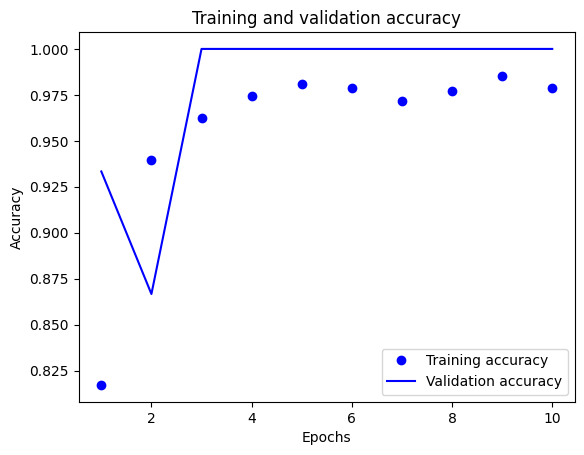

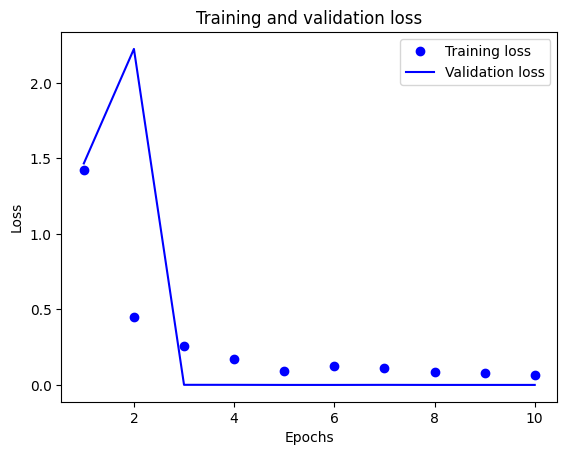

In [73]:
# plot accuracy for train and validation
# Accuracy for training and validation
accuracy = history.history["accuracy"]
validation_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
validation_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

# Plot training and validation accuracy
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, validation_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, validation_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [74]:
test_loss, test_acc = model.evaluate(validation_generator)
print(test_acc)

1/1 [==============================] - 1s 922ms/step - loss: 4.7444e-06 - accuracy: 1.0000
1.0


In [76]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(validation_generator)
y_pred_class = np.argmax(y_pred, axis=1)

y_true = validation_generator.classes

# confusion matrix
cm = confusion_matrix(y_true, y_pred_class)

# precision, recall and F1-score
print(classification_report(y_true, y_pred_class, target_names=validation_generator.class_indices.keys()))

1/1 [==============================] - 1s 862ms/step
                  precision    recall  f1-score   support

D-ARNAUDS BARBET       0.40      0.40      0.40         5
     HOUSE FINCH       0.40      0.40      0.40         5
    RUFOUS TREPE       0.60      0.60      0.60         5

        accuracy                           0.47        15
       macro avg       0.47      0.47      0.47        15
    weighted avg       0.47      0.47      0.47        15



AUC for D-ARNAUDS BARBET: 0.47649184149184143
AUC for HOUSE FINCH: 0.514978354978355
AUC for RUFOUS TREPE: 0.6142207792207792


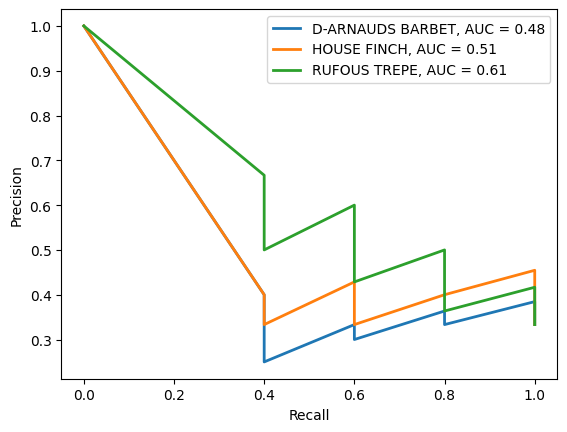

In [77]:
# convert true labels to one-hot encoding for multi-class
from keras.utils import to_categorical
from sklearn.metrics import precision_recall_curve, auc

y_true_one_hot = to_categorical(y_true)
class_names = {v: k for k, v in validation_generator.class_indices.items()}

for i in range(3):
    precision, recall, _ = precision_recall_curve(y_true_one_hot[:, i], y_pred[:, i])
    auc_score = auc(recall, precision)
    class_name = class_names[i]
    print(f'AUC for {class_name}: {auc_score}')
    plt.plot(recall, precision, lw=2, label='{}, AUC = {:.2f}'.format(class_name, auc_score))

# plot

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

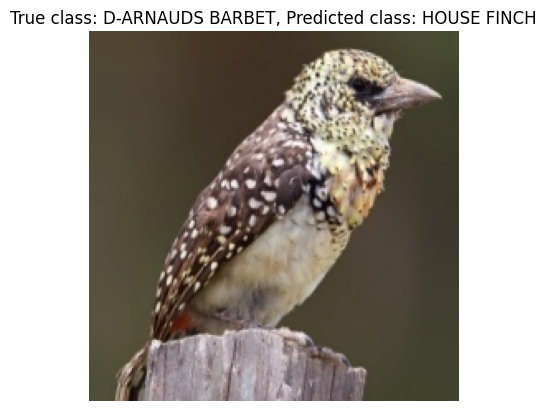

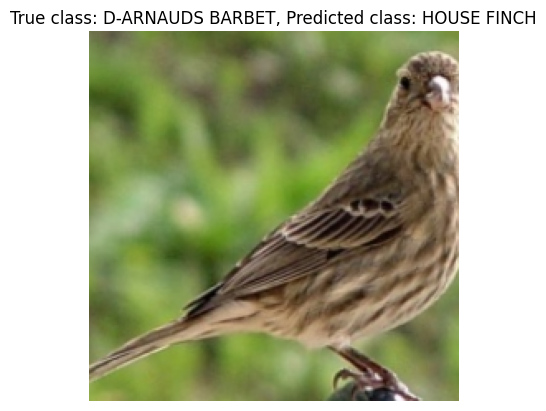

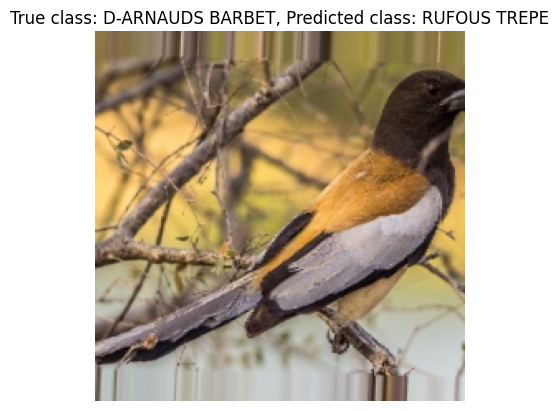

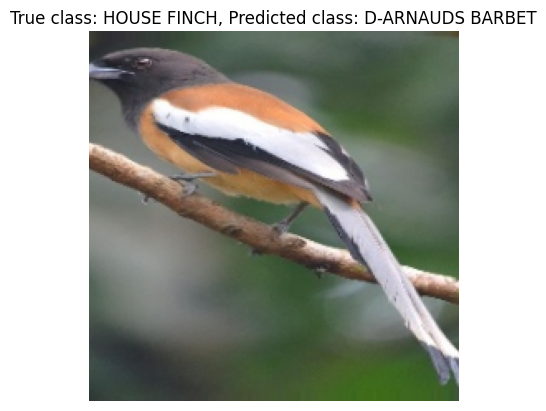

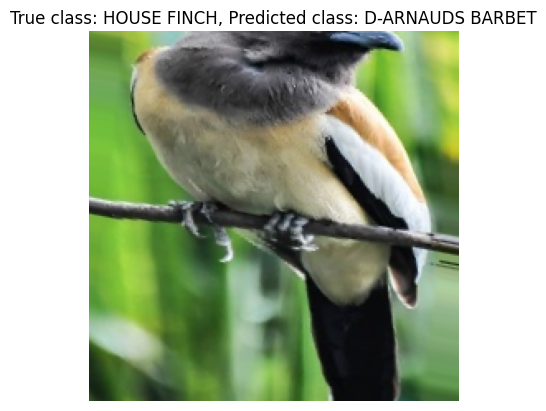

In [78]:
# explore incorrectly predicted examples
misclassfied_index = np.where(y_pred_class != y_true)[0]

# plot 5 misclassfied examples
for index in misclassfied_index[:5]:
    img_batch, _ = validation_generator[index // validation_generator.batch_size]
    img = img_batch[index % validation_generator.batch_size]
    
    true_class_name = class_names[y_true[index]]
    predicted_class_name = class_names[y_pred_class[index]]

    plt.imshow(img.astype('uint8'))
    plt.title(f'True class: {true_class_name}, Predicted class: {predicted_class_name}')
    plt.axis('off')
    plt.show()